In [187]:

import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from decomposition import DecompositionLayer
torch.set_num_threads(9)

class MyDataset(TensorDataset):
    def __init__(self, data, window):
        self.data = data
        self.window = window

    def __getitem__(self, index):
        x = self.data[index:index+self.window]
        return x

    def __len__(self):
        return len(self.data) - self.window

In [188]:
input_size = 150
pred = input_size
learning_rate = 0.0001

data_size  = 6000
step = 1
m = 100 #на сколько шагов предсказать
data_set = 3000

In [189]:
class DecompositionLayer(nn.Module):
    """
    Returns the trend and the seasonal parts of the time series.
    """

    def __init__(self, kernel_size):
        super().__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=1, padding=0) # moving average 

    def forward(self, x):
        """Input shape: Batch x Time x EMBED_DIM"""
        # padding on the both ends of time series
        num_of_pads = (self.kernel_size) // 2
        front = x[:, 0:1, :].repeat(1, num_of_pads, 1)
        end = x[:, -1:, :].repeat(1, num_of_pads, 1)
        x_padded = torch.cat([front, x, end], dim=1)

        # calculate the trend and seasonal part of the series
        x_trend = self.avg(x_padded.permute(0, 2, 1))[:,:,:-1].permute(0, 2, 1)
        #print(x_trend.shape)
        x_seasonal = x - x_trend
        return x_seasonal, x_trend

In [190]:
class DLinearModel(nn.Module):
    def __init__(self, input_size):
        super(DLinearModel, self).__init__()
        self.linear_seasonal = nn.Linear(input_size, 1)
        self.linear_trend = nn.Linear(input_size, 1)
        self.decomposition = DecompositionLayer(input_size)
        self.bias = nn.Parameter(torch.zeros(1))
        
    def forward(self, context):
        seasonal, trend = self.decomposition(context)
        #print(seasonal, trend)
        seasonal_output = self.linear_seasonal(seasonal.reshape(1, 1, -1))
        trend_output = self.linear_trend(trend.reshape(1, 1, -1))
        
        return seasonal_output + trend_output


def train_model(model, dataloader, criterion, optimizer, num_epochs=100):
    for epoch in range(num_epochs):
        print("Epoch = ", epoch)
        for X in dataloader:
            
            optimizer.zero_grad()
            output = model.forward(X)
            loss = criterion(output, X)
            loss.backward()
            optimizer.step()


In [191]:

data = pd.read_csv('ETTh1.csv')  
X = torch.tensor(data['HUFL'].values[:data_size:step], dtype=torch.float32).view(-1, 1)
x = pd.read_csv("ETTh1.csv").HUFL

In [192]:
model = DLinearModel(input_size)
criterion = nn.SmoothL1Loss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
#optimizer = optim.Adam(model.parameters(), lr=learning_rate)


window_size = input_size  # Размер окна для rolling window forecasting
#переписать

dataset = MyDataset(X, window_size)

#print(x.rolling(window_size))

dataloader = DataLoader(dataset)#, shuffle=True)

In [193]:
len(dataloader)

5850

In [194]:
train_model(model, dataloader, criterion, optimizer)


Epoch =  0


c:\Users\evgen\miniconda3\envs\MyDLinear\Lib\site-packages\torch\nn\modules\loss.py:933: UserWarning: Using a target size (torch.Size([1, 150, 1])) that is different to the input size (torch.Size([1, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


Epoch =  1
Epoch =  2
Epoch =  3
Epoch =  4
Epoch =  5
Epoch =  6
Epoch =  7
Epoch =  8
Epoch =  9
Epoch =  10
Epoch =  11
Epoch =  12
Epoch =  13
Epoch =  14
Epoch =  15
Epoch =  16
Epoch =  17
Epoch =  18
Epoch =  19
Epoch =  20
Epoch =  21
Epoch =  22
Epoch =  23
Epoch =  24
Epoch =  25
Epoch =  26
Epoch =  27
Epoch =  28
Epoch =  29
Epoch =  30
Epoch =  31
Epoch =  32
Epoch =  33
Epoch =  34
Epoch =  35
Epoch =  36
Epoch =  37
Epoch =  38
Epoch =  39
Epoch =  40
Epoch =  41
Epoch =  42
Epoch =  43
Epoch =  44
Epoch =  45
Epoch =  46
Epoch =  47
Epoch =  48
Epoch =  49
Epoch =  50
Epoch =  51
Epoch =  52
Epoch =  53
Epoch =  54
Epoch =  55
Epoch =  56
Epoch =  57
Epoch =  58
Epoch =  59
Epoch =  60
Epoch =  61
Epoch =  62
Epoch =  63
Epoch =  64
Epoch =  65
Epoch =  66
Epoch =  67
Epoch =  68
Epoch =  69
Epoch =  70
Epoch =  71
Epoch =  72
Epoch =  73
Epoch =  74
Epoch =  75
Epoch =  76
Epoch =  77
Epoch =  78
Epoch =  79
Epoch =  80
Epoch =  81
Epoch =  82
Epoch =  83
Epoch =  84
E

In [195]:
torch.save(model.state_dict(), "test_model_v7_SL1")

In [196]:
model.load_state_dict(torch.load("test_model_v7_SL1"))
model.eval()

DLinearModel(
  (linear_seasonal): Linear(in_features=150, out_features=1, bias=True)
  (linear_trend): Linear(in_features=150, out_features=1, bias=True)
  (decomposition): DecompositionLayer(
    (avg): AvgPool1d(kernel_size=(150,), stride=(1,), padding=(0,))
  )
)

In [197]:
model.parameters

<bound method Module.parameters of DLinearModel(
  (linear_seasonal): Linear(in_features=150, out_features=1, bias=True)
  (linear_trend): Linear(in_features=150, out_features=1, bias=True)
  (decomposition): DecompositionLayer(
    (avg): AvgPool1d(kernel_size=(150,), stride=(1,), padding=(0,))
  )
)>

In [198]:
def predict_future_values(model, X_f, window_size, m):
    #predicted_values = initial_values.clone().detach().view(-1).tolist()
    predicted_values = []
    
    for i in range(m):
        
        
        #проверить что модель принимает нужный набор значений
        #last_X = torch.tensor([predicted_values[-1]], dtype=torch.float32).view(-1, 1)
        # last_X_t = torch.tensor([predicted_values[-1]], dtype=torch.float32).view(-1, 1)
        
        prediction = model(X_f)

        
        predicted_values.append(prediction.tolist()[-1][-1][-1])
        if(window_size > i):
            
            X_f = torch.tensor(data['HUFL'].values[data_size-window_size+i+1::step] + predicted_values, dtype=torch.float32).reshape(1, 1, -1)
        else:
            X_f = torch.tensor(predicted_values, dtype=torch.float32).reshape(1, 1, -1)
            
        

    return predicted_values

In [199]:
initial_values = torch.cat([X[-input_size:]]).reshape(1, 1, -1)

pred = input_size
X_f = torch.tensor(data['HUFL'].values[data_set-pred:data_set], dtype=torch.float32).view(-1, 1)
print(X_f)
dataset_f = MyDataset(X_f, pred)
print(dataset_f.data)
#print(x.rolling(window_size))

dataloader_f = DataLoader(dataset_f)#, shuffle=True)

X_f


tensor([[ 8.5730],
        [ 8.1720],
        [ 6.9660],
        [ 6.4300],
        [ 5.6930],
        [ 8.8410],
        [10.7170],
        [ 9.9800],
        [ 8.1050],
        [ 8.7070],
        [ 9.1090],
        [ 8.9080],
        [ 9.0420],
        [11.3200],
        [ 8.5730],
        [ 7.9040],
        [ 9.1760],
        [10.1810],
        [ 7.5690],
        [ 7.4350],
        [ 7.6360],
        [ 7.7700],
        [ 7.3680],
        [ 8.6400],
        [ 7.5690],
        [ 6.7650],
        [ 6.0280],
        [ 6.8990],
        [ 7.7030],
        [ 8.8410],
        [13.1950],
        [12.4580],
        [13.1280],
        [12.7930],
        [12.9270],
        [13.3960],
        [12.8600],
        [16.3430],
        [10.5830],
        [ 9.1760],
        [ 9.3100],
        [10.0470],
        [ 7.9710],
        [ 7.9710],
        [ 7.4350],
        [ 7.3010],
        [ 7.2340],
        [ 8.6400],
        [ 7.6360],
        [ 6.7650],
        [ 6.5640],
        [ 5.6260],
        [ 6.

tensor([[ 8.5730],
        [ 8.1720],
        [ 6.9660],
        [ 6.4300],
        [ 5.6930],
        [ 8.8410],
        [10.7170],
        [ 9.9800],
        [ 8.1050],
        [ 8.7070],
        [ 9.1090],
        [ 8.9080],
        [ 9.0420],
        [11.3200],
        [ 8.5730],
        [ 7.9040],
        [ 9.1760],
        [10.1810],
        [ 7.5690],
        [ 7.4350],
        [ 7.6360],
        [ 7.7700],
        [ 7.3680],
        [ 8.6400],
        [ 7.5690],
        [ 6.7650],
        [ 6.0280],
        [ 6.8990],
        [ 7.7030],
        [ 8.8410],
        [13.1950],
        [12.4580],
        [13.1280],
        [12.7930],
        [12.9270],
        [13.3960],
        [12.8600],
        [16.3430],
        [10.5830],
        [ 9.1760],
        [ 9.3100],
        [10.0470],
        [ 7.9710],
        [ 7.9710],
        [ 7.4350],
        [ 7.3010],
        [ 7.2340],
        [ 8.6400],
        [ 7.6360],
        [ 6.7650],
        [ 6.5640],
        [ 5.6260],
        [ 6.

In [200]:
X_t = X_f.tolist()
X_t

[[8.572999954223633],
 [8.17199993133545],
 [6.966000080108643],
 [6.429999828338623],
 [5.692999839782715],
 [8.840999603271484],
 [10.717000007629395],
 [9.979999542236328],
 [8.104999542236328],
 [8.706999778747559],
 [9.109000205993652],
 [8.907999992370605],
 [9.041999816894531],
 [11.319999694824219],
 [8.572999954223633],
 [7.9039998054504395],
 [9.175999641418457],
 [10.180999755859375],
 [7.568999767303467],
 [7.434999942779541],
 [7.636000156402588],
 [7.769999980926514],
 [7.368000030517578],
 [8.640000343322754],
 [7.568999767303467],
 [6.764999866485596],
 [6.0279998779296875],
 [6.89900016784668],
 [7.703000068664551],
 [8.840999603271484],
 [13.194999694824219],
 [12.458000183105469],
 [13.128000259399414],
 [12.793000221252441],
 [12.927000045776367],
 [13.395999908447266],
 [12.859999656677246],
 [16.343000411987305],
 [10.583000183105469],
 [9.175999641418457],
 [9.3100004196167],
 [10.04699993133545],
 [7.9710001945495605],
 [7.9710001945495605],
 [7.434999942779541]

In [201]:

predicted_values = []



for i in range(m):
    
    
    #проверить что модель принимает нужный набор значений
    #last_X = torch.tensor([predicted_values[-1]], dtype=torch.float32).view(-1, 1)
    # last_X_t = torch.tensor([predicted_values[-1]], dtype=torch.float32).view(-1, 1)
    
    
    
    
    X = torch.tensor([X_t])
    print(X)
    prediction = model(X)
    predicted_values.append(prediction.tolist()[-1][-1][-1])
    X_next = prediction.tolist()[-1][-1]
    
    X_t.append(X_next)
    X_t = X_t[1:]
    dataset_f = MyDataset(X_t, window_size)
        
    


future_predictions = predicted_values

tensor([[[ 8.5730],
         [ 8.1720],
         [ 6.9660],
         [ 6.4300],
         [ 5.6930],
         [ 8.8410],
         [10.7170],
         [ 9.9800],
         [ 8.1050],
         [ 8.7070],
         [ 9.1090],
         [ 8.9080],
         [ 9.0420],
         [11.3200],
         [ 8.5730],
         [ 7.9040],
         [ 9.1760],
         [10.1810],
         [ 7.5690],
         [ 7.4350],
         [ 7.6360],
         [ 7.7700],
         [ 7.3680],
         [ 8.6400],
         [ 7.5690],
         [ 6.7650],
         [ 6.0280],
         [ 6.8990],
         [ 7.7030],
         [ 8.8410],
         [13.1950],
         [12.4580],
         [13.1280],
         [12.7930],
         [12.9270],
         [13.3960],
         [12.8600],
         [16.3430],
         [10.5830],
         [ 9.1760],
         [ 9.3100],
         [10.0470],
         [ 7.9710],
         [ 7.9710],
         [ 7.4350],
         [ 7.3010],
         [ 7.2340],
         [ 8.6400],
         [ 7.6360],
         [ 6.7650],


In [202]:
future_predictions

[10.695974349975586,
 10.706418991088867,
 10.67552661895752,
 10.674138069152832,
 10.651692390441895,
 10.807766914367676,
 10.843504905700684,
 10.796582221984863,
 10.693357467651367,
 10.752812385559082,
 10.778955459594727,
 10.772974014282227,
 10.787899017333984,
 10.905344009399414,
 10.823942184448242,
 10.847707748413086,
 10.947378158569336,
 10.988913536071777,
 10.911539077758789,
 10.931934356689453,
 10.971122741699219,
 11.002276420593262,
 11.016149520874023,
 11.059500694274902,
 11.024417877197266,
 11.026775360107422,
 11.038969039916992,
 11.125567436218262,
 11.168792724609375,
 11.210341453552246,
 11.372260093688965,
 11.301467895507812,
 11.287598609924316,
 11.232117652893066,
 11.19456672668457,
 11.181166648864746,
 11.100852012634277,
 11.238024711608887,
 10.902066230773926,
 10.843079566955566,
 10.85361099243164,
 10.876893043518066,
 10.811355590820312,
 10.824660301208496,
 10.797295570373535,
 10.809020042419434,
 10.824173927307129,
 10.893282890319

In [203]:
len(future_predictions)

100

Future Predictions: [10.695974349975586, 10.706418991088867, 10.67552661895752, 10.674138069152832, 10.651692390441895, 10.807766914367676, 10.843504905700684, 10.796582221984863, 10.693357467651367, 10.752812385559082, 10.778955459594727, 10.772974014282227, 10.787899017333984, 10.905344009399414, 10.823942184448242, 10.847707748413086, 10.947378158569336, 10.988913536071777, 10.911539077758789, 10.931934356689453, 10.971122741699219, 11.002276420593262, 11.016149520874023, 11.059500694274902, 11.024417877197266, 11.026775360107422, 11.038969039916992, 11.125567436218262, 11.168792724609375, 11.210341453552246, 11.372260093688965, 11.301467895507812, 11.287598609924316, 11.232117652893066, 11.19456672668457, 11.181166648864746, 11.100852012634277, 11.238024711608887, 10.902066230773926, 10.843079566955566, 10.85361099243164, 10.876893043518066, 10.811355590820312, 10.824660301208496, 10.797295570373535, 10.809020042419434, 10.824173927307129, 10.893282890319824, 10.855597496032715, 10

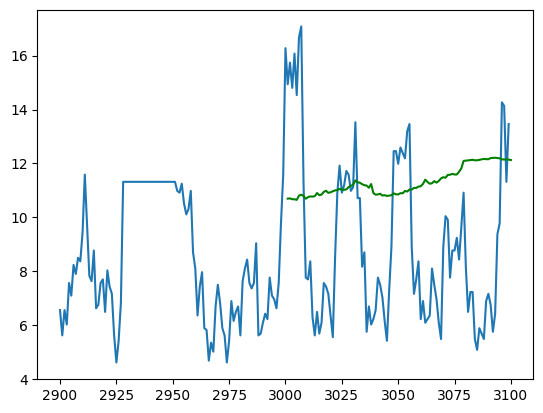

<Figure size 640x480 with 0 Axes>

In [204]:
print("Future Predictions:", future_predictions)
time = [data_set-m+i for i in range(2*m)]
plt.plot(time, data['HUFL'].values[data_set-m:data_set+m:step])
#plt.plot(, )
pred = data['HUFL'].values[data_set-1]
time = [data_set+1+i for i in range(m, step)]

    
plt.plot(time, future_predictions, 'g-')

plt.show()
plt.savefig("forecast", dpi=200)


